## Deep Learning with PyTorch : Neural Style Transfer

## Task 1 : Set Google Colab runtime

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

# 1 Cài đặt các gói thư viện cần thiết

In [ ]:
!pip install torch torchvision

In [ ]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 19 (delta 2), reused 1 (delta 1), pack-reused 16
Receiving objects: 100% (19/19), 3.30 MiB | 44.45 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 2 : Tiền xử lý ảnh

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
from PIL import Image
from torchvision import transforms as T

In [ ]:
def preprocess(img_path,max_size=500):
  #Load Image
  image = Image.open(img_path).convert('RGB')
  #Lấy size
  size = min(max(image.size),max_size)

  #Transform compese là làm chuỗi biến đổi
  img_trans = T.Compose([
            T.Resize(size),
            T.ToTensor(), #no se chuyen size
            T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
  ])
  image = img_trans(image)
  image = image.unsqueeze(0) # thêm chiều để phù hợp với model
  return image


Ta sẽ tiền xử lý ảnh content và style

In [ ]:
content_p = preprocess('/content/ve-chan-dung-40.jpg')
style_p = preprocess('/content/van.jpg')

In [ ]:
content_p = content_p.to(device)
style_p = style_p.to(device)

# 3: Chuyển ảnh đã qua xử lý về lại dạng thường

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Sau khi đã tiền xử lý và đưa vào model, ta sẽ được đầu ra có đặc điểm giống ảnh đã qua xử lý, vì vậy ta phải đưa nó về dạng ảnh thường để hiển thị

In [ ]:
def deprocess(tensor):
   image = tensor.to('cpu').clone()
   #chuyen sang numpy de xu ly
   image = image.numpy()
   image = image.squeeze(0)
   image = image.transpose(1,2,0) #chuyen lai size tu tensor
   image = image * np.array([0.485, 0.456, 0.406]) + np.array([0.229, 0.224, 0.225])
   image = image.clip(0,1)

   return image


Deprocess các ảnh đã qua xử lý và hiển thị

In [ ]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

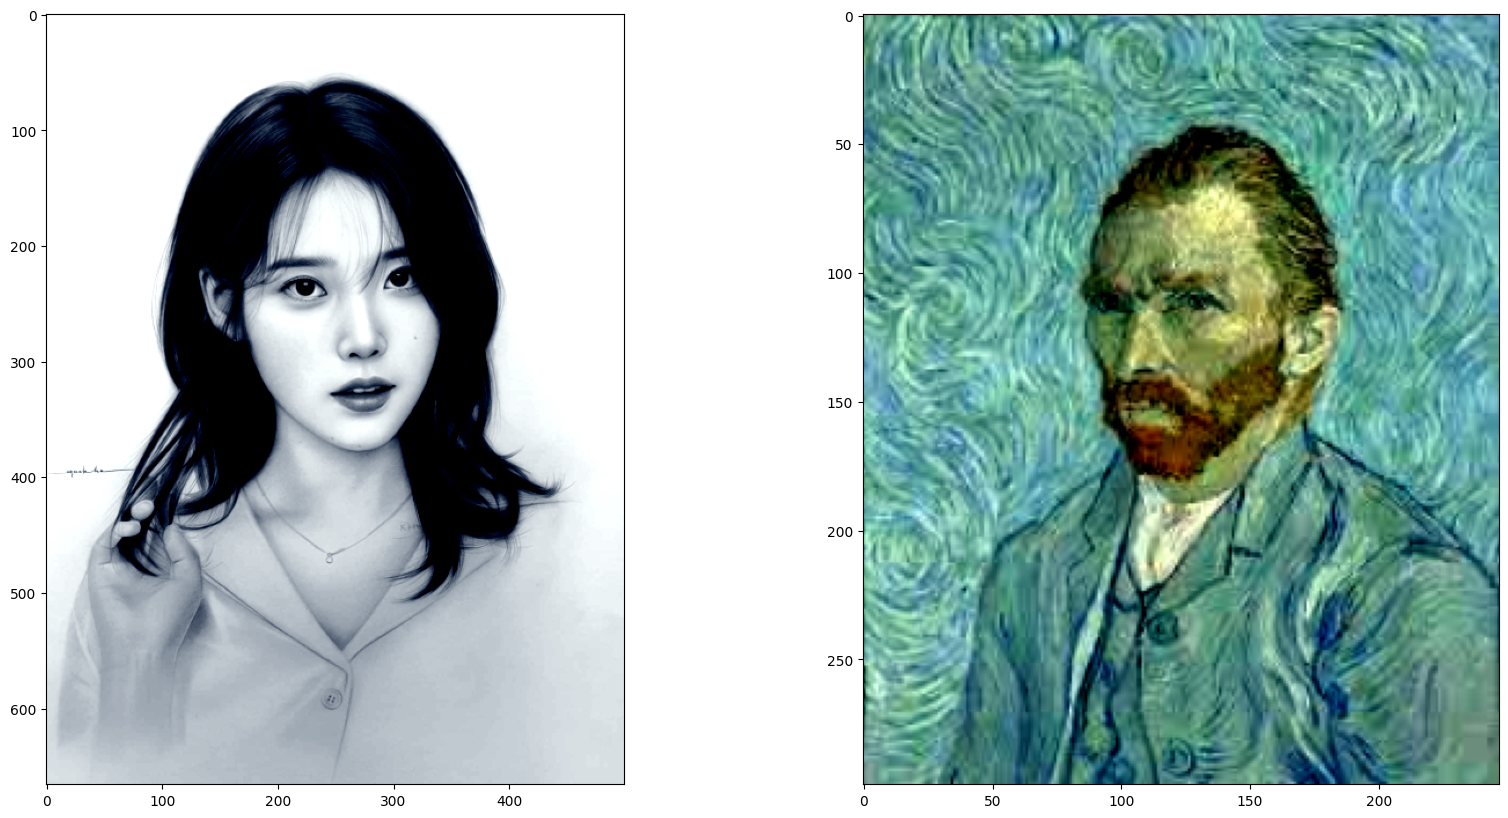

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (20,10))
ax[0].imshow(content_d)
ax[1].imshow(style_d)

# 4 : Loading VGG Pretrained Model

In [ ]:

from torchvision import models

Ta sẽ sử dụng model VGG19

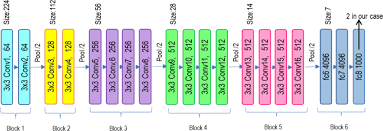

In [ ]:
vgg = models.vgg19(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 111MB/s]


In [ ]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Ta se chỉ sử dụng phần features trong model này

In [ ]:
vgg = vgg.features
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
for parameters in vgg.parameters():
  parameters.requires_grad_(False)


In [ ]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 5: Tạo content,style features và ma trận gram.

In [ ]:
def get_features(image,model):
  layers = {
      '0' : 'conv1_1',# các lớp dùng cho hàm loss style
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2', #Lớp này dùng cho hàm loss content
      '28' : 'conv5_1'
  }
  x = image
  # Luu gia tri cac lop can thiet
  Features = {}

  for name,layer in model._modules.items():
    x = layer(x)

    if name in layers:
      Features[layers[name]] = x
  return Features

In [ ]:
content_f = get_features(content_p,vgg)
style_f = get_features(style_p,vgg)

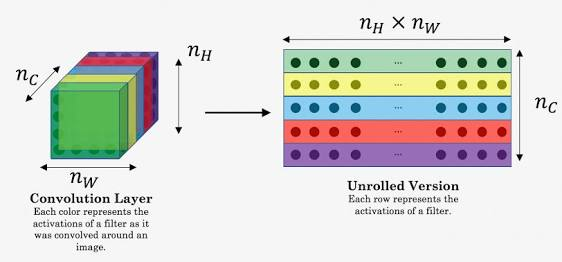

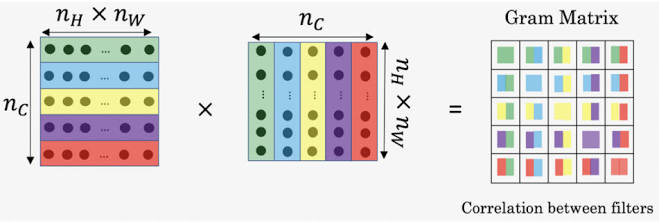

Ta tạo ma trận Gram cho Loss style

In [ ]:
def gram_matrix(tensor):
  b,c,h,w = tensor.size()
  tensor = tensor.view(c,w*h)
  gram = torch.mm(tensor,tensor.t())
  return gram

In [ ]:
style_grams = {layer : gram_matrix(style_f[layer]) for layer in style_f}

In [ ]:
style_grams

{'conv1_1': tensor([[5.4211e+03, 6.0561e+03, 3.7036e+02,  ..., 4.8344e+03, 2.6865e+03,
          6.1471e+03],
         [6.0561e+03, 3.7327e+04, 1.5157e+02,  ..., 8.5861e+03, 7.3245e+03,
          1.4805e+04],
         [3.7036e+02, 1.5157e+02, 2.4137e+02,  ..., 7.5090e+00, 1.2327e+02,
          3.1494e+02],
         ...,
         [4.8344e+03, 8.5861e+03, 7.5090e+00,  ..., 1.3823e+04, 7.2814e+03,
          1.0469e+04],
         [2.6865e+03, 7.3245e+03, 1.2327e+02,  ..., 7.2814e+03, 7.9192e+03,
          8.2299e+03],
         [6.1471e+03, 1.4805e+04, 3.1494e+02,  ..., 1.0469e+04, 8.2299e+03,
          1.7488e+04]], device='cuda:0'),
 'conv2_1': tensor([[62722.5859,  3157.3501, 38044.4102,  ..., 28874.0645,  6843.3032,
          17440.2227],
         [ 3157.3501,  8580.0684,  6519.4585,  ...,  8142.2075,  3102.7610,
           3099.6213],
         [38044.4102,  6519.4585, 71420.5078,  ..., 35378.7422,  7428.7285,
          19746.6094],
         ...,
         [28874.0645,  8142.2075, 35378.

# 6: Tạo các hàm Loss

In [ ]:
def content_loss(target_conv4_2,content_conv4_2):
  loss = torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

In [ ]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

In [ ]:
def style_loss(style_weights,target_features,style_grams):
  loss = 0
  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.size()
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss/(c*h*w)
  return loss

Tạo ảnh target dựa trên ảnh content

In [ ]:
target = content_p.clone().requires_grad_(True).to(device)

# 7: Train ảnh target

In [ ]:
from torch import optim

optimizer = optim.Adam([target],lr = 0.01)

alpha = 1
beta = 1

epoch = 3000
show_every =300

In [ ]:
def total_loss(c_loss,s_loss,alpha,beta):
  loss = alpha * c_loss + beta * s_loss
  return loss

In [ ]:
results = []

for i in range(epoch):
  target_f = get_features(target,vgg)

  c_loss = content_loss(target_f['conv4_2'],content_f['conv4_2'])
  s_loss = style_loss(style_weights,target_f,style_grams)
  t_loss = total_loss(c_loss,s_loss,alpha,beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print('Total loss at epoch {} : {}'.format(i,t_loss))
    results.append(deprocess(target.detach()))

Total loss at epoch 0 : 74.13825988769531
Total loss at epoch 300 : 21.789722442626953
Total loss at epoch 600 : 18.93366241455078
Total loss at epoch 900 : 18.110280990600586
Total loss at epoch 1200 : 17.726823806762695
Total loss at epoch 1500 : 17.499536514282227
Total loss at epoch 1800 : 17.351877212524414
Total loss at epoch 2100 : 17.25668716430664
Total loss at epoch 2400 : 17.19239044189453
Total loss at epoch 2700 : 17.144132614135742


# 8: Xem kết quả

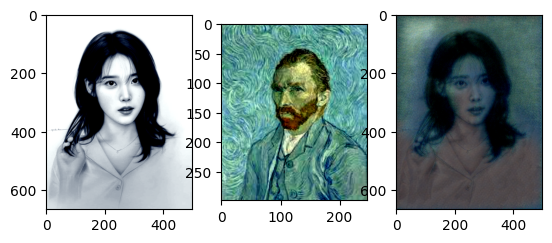

In [ ]:
fig,ax = plt.subplots(1,3)
ax[0].imshow(content_d)
ax[1].imshow(style_d)
ax[2].imshow(deprocess(target.detach()))
plt.show()